**Food Delivery  Data Integration  Hackathon**

**PHASE 1: Step-by-Step – Combining the Datasets**

Step 1: Import Libraries

In [1]:
import pandas as pd
import sqlite3


Step 2: Load orders.csv

In [2]:
orders = pd.read_csv("orders.csv")

print("Orders rows:", orders.shape[0])

Orders rows: 10000


Step 3: Load users.json

In [3]:
users = pd.read_json("users.json")

Step 4: Load restaurants.sql

In [4]:
conn = sqlite3.connect(":memory:")

with open("restaurants.sql", "r") as file:
    sql_script = file.read()

conn.executescript(sql_script)

restaurants = pd.read_sql("SELECT * FROM restaurants", conn)


Step 5: LEFT JOIN orders + users

In [5]:
orders_users = orders.merge(
    users,
    on="user_id",
    how="left"
)


Step 6: LEFT JOIN with restaurants

In [6]:
final_df = orders_users.merge(
    restaurants,
    on="restaurant_id",
    how="left"
)


Step 7: Export the final file

In [7]:
final_df.to_csv("final_food_delivery_dataset.csv", index=False)


Step 7: Verify Final Row Count

In [8]:
print("Final merged rows:", final_df.shape[0])


Final merged rows: 10000


**PHASE 2: Analyze from Final Dataset**

1. Order trends over time

In [9]:
final_df["order_date"] = pd.to_datetime(final_df["order_date"])
final_df.groupby(final_df["order_date"].dt.month)["total_amount"].sum()


/tmp/ipython-input-1182942265.py:1: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  final_df["order_date"] = pd.to_datetime(final_df["order_date"])


,total_amount
order_date,
1,663020.26
2,630867.40
3,716738.98
4,666097.18
5,668428.61
6,610822.93
7,688559.45
8,694987.58
9,653838.07


2. User behavior patterns



a. Gold vs Regular Orders

In [10]:
# Order count by membership
final_df.groupby("membership")["order_id"].count()


,order_id
membership,
Gold,4987
Regular,5013


In [11]:
# Revenue by membership
final_df.groupby("membership")["total_amount"].sum()


,total_amount
membership,
Gold,3975364.89
Regular,4036259.23


<Axes: title={'center': 'Orders by Membership'}, xlabel='membership'>

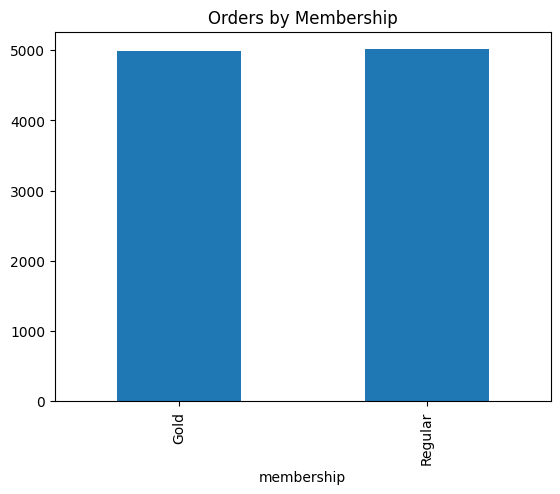

In [12]:
final_df.groupby("membership")["order_id"].count().plot(kind="bar", title="Orders by Membership")


b. Repeat Users

In [13]:
orders_per_user = final_df.groupby("user_id")["order_id"].count()

repeat_users = orders_per_user[orders_per_user > 1]

repeat_users.count()


np.int64(2539)

In [14]:
orders_per_user.value_counts().head()


,count
order_id,
3,713
2,593
4,519
5,353
1,344


c. High Spenders

In [15]:
spend_per_user = final_df.groupby("user_id")["total_amount"].sum()

high_spenders = spend_per_user[spend_per_user > 1000]

high_spenders.count()


np.int64(2544)

In [16]:
high_spenders.sort_values(ascending=False).head(10)


,total_amount
user_id,
1515,11556.49
650,10747.44
496,9634.30
2586,9486.61
2615,9237.32
636,9087.09
2973,9063.07
874,8916.55
1337,8907.50


Combine Behavior with Membership


In [17]:
#Gold vs Regular repeat users
final_df.groupby(["membership", "user_id"])["order_id"].count().reset_index()


,membership,user_id,order_id
0,Gold,2,10
1,Gold,3,2
2,Gold,5,5
3,Gold,6,3
4,Gold,7,7
...,...,...,...
2878,Regular,2992,5
2879,Regular,2995,2
2880,Regular,2997,5
2881,Regular,2998,6


In [18]:
#High spenders by membership
final_df.groupby(["membership", "user_id"])["total_amount"].sum().reset_index()


,membership,user_id,total_amount
0,Gold,2,7564.12
1,Gold,3,1839.51
2,Gold,5,5742.88
3,Gold,6,3728.23
4,Gold,7,7352.75
...,...,...,...
2878,Regular,2992,3964.06
2879,Regular,2995,2472.66
2880,Regular,2997,5310.32
2881,Regular,2998,4241.47


3. City-wise & cuisine-wise performance

In [19]:
final_df.groupby("city")["total_amount"].sum()
final_df.groupby("cuisine")["total_amount"].mean()


,total_amount
cuisine,
Chinese,798.389020
Indian,798.466011
Italian,799.448578
Mexican,808.021344


4. Membership impact

In [21]:
final_df.columns


Index(['order_id', 'user_id', 'restaurant_id', 'order_date', 'total_amount',
       'restaurant_name_x', 'name', 'city', 'membership', 'restaurant_name_y',
       'cuisine', 'rating'],
      dtype='object')

In [22]:
final_df.groupby("membership")["total_amount"].agg(["sum", "mean", "count"])


,sum,mean,count
membership,,,
Gold,3975364.89,797.145556,4987
Regular,4036259.23,805.158434,5013


5. Revenue distribution & seasonality

In [23]:
final_df["quarter"] = final_df["order_date"].dt.to_period("Q")
final_df.groupby("quarter")["total_amount"].sum()


,total_amount
quarter,
2023Q1,1993425.14
2023Q2,1945348.72
2023Q3,2037385.10
2023Q4,2018263.66
2024Q1,17201.50
